# Discrete Anomaly Detection Exercises

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

### Redoing the stuff from the curriculum 

In [2]:
# acquire data with code from curriculum 

colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
# have 7 columns, and 13978 rows
df.shape

(13978, 7)

In [5]:
# need to fix this 
df.timestamp.head(3)

0    [16/Apr/2019:19:34:42 +0000]
1    [16/Apr/2019:19:34:42 +0000]
2    [16/Apr/2019:19:34:44 +0000]
Name: timestamp, dtype: object

In [6]:
# this uses regular expressions to take out the +0000 at the end
df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)

In [7]:
# result
df.timestamp.head(3)

0    16/Apr/2019:19:34:42 
1    16/Apr/2019:19:34:42 
2    16/Apr/2019:19:34:44 
Name: timestamp, dtype: object

In [8]:
# replace first : with ' ' (space)
# and convert to datetime
df.timestamp = pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))

In [9]:
df.timestamp.head(3)

0   2019-04-16 19:34:42
1   2019-04-16 19:34:42
2   2019-04-16 19:34:44
Name: timestamp, dtype: datetime64[ns]

In [10]:
# set timestamp col as datetime index
df = df.set_index('timestamp')

In [11]:
# Clean up the text in the request method request agent and destination columns
# need to get rid of quotations because pandas handles it as a string anyway

for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

In [12]:
df.head(3)

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales?page=81 HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales?page=82 HTTP/1.1,200,510103,NaN,python-requests/2.21.0


In [13]:
# get rid of the page number stuff so we can categorize the methods

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

In [14]:
df.head(3)

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0


In [15]:
# convert Bytes to MB that is 1024^2
# so we divide by 1024 twice

df['size_mb'] = [n/1024/1024 for n in df['size']]

In [16]:
df.head(3)

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472


In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
status,13978.0,200.356703,10.182001,200.0,200.000000,200.000000,200.000000,4.990000e+02
size,13978.0,450001.905781,161491.467157,0.0,500637.000000,510138.000000,511291.000000,2.056327e+06
size_mb,13978.0,0.429155,0.154010,0.0,0.477445,0.486506,0.487605,1.961066e+00


In [18]:
pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
            rename(index = str, columns={'index': 'ip', 'ip': 'ip_count'})

,ip,ip_count
0,97.105.19.58,11999
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,24.26.242.9,21
5,68.201.219.223,21
6,70.121.214.34,2
7,52.87.230.102,2
8,35.175.171.137,2
9,35.174.209.2,1


In [19]:
pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

,ip,ip_proba
0,97.105.19.58,0.858420
1,173.173.113.51,0.075762
2,72.181.113.170,0.043855
3,72.181.105.81,0.017599
4,24.26.242.9,0.001502
5,68.201.219.223,0.001502
6,70.121.214.34,0.000143
7,52.87.230.102,0.000143
8,35.175.171.137,0.000143
9,35.174.209.2,0.000072


In [20]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
            rename(index = str, columns={'index': 'ip', 'ip': 'ip_count'})

ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

ip_df = ip_df.merge(ip_df2)


In [21]:
ip_df[ip_df.ip_proba < .01]

,ip,ip_count,ip_proba
4,24.26.242.9,21,0.001502
5,68.201.219.223,21,0.001502
6,70.121.214.34,2,0.000143
7,52.87.230.102,2,0.000143
8,35.175.171.137,2,0.000143
9,35.174.209.2,1,0.000072
10,54.172.14.223,1,0.000072
11,95.31.18.119,1,0.000072
12,95.31.16.121,1,0.000072
13,52.90.165.200,1,0.000072


22
               ip  ip_count  ip_proba
12   95.31.16.121         1  0.000072
13  52.90.165.200         1  0.000072
14   52.91.30.150         1  0.000072
15   45.23.250.16         1  0.000072
16  97.105.15.120         1  0.000072
17  54.145.52.184         1  0.000072
18  34.207.64.242         1  0.000072
19  34.229.70.250         1  0.000072
20   3.88.129.158         1  0.000072
21   3.92.201.136         1  0.000072


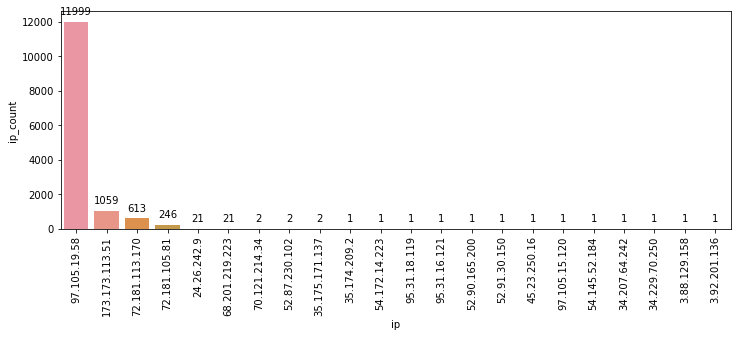

In [22]:
print(len(ip_df))

print(ip_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

plt.show()

### Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

In [23]:
df.request_method.value_counts()

GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/ HTTP/1.1                               4
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1/store HTTP/1.1                          3
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1/sales/HTTP/1.1                          3
GET /api/v1items HTTP/1.1                           2
GET /api/v1 HTTP/1.1                                1
GET /api/v1/helloclass! HTTP/1.1                    1
GET /api/v1/items&page=0 HTTP/1.1                   1
GET /api/V1/HiZach! HTTP/1.1

In [24]:
df['request_method'] = df.request_method.str.replace('HTTP/1.1', '')

In [25]:
df.request_method.value_counts()

GET /api/v1/sales                       12403
GET /api/v1/items                        1065
GET /api/v1/stores                        229
GET /                                     107
GET /documentation                        100
GET /favicon.ico                           26
GET /api/v1//api/v1/items                  11
GET /api/v1/items/api/v1/items              7
GET /api/v1/items/next_page                 5
GET /api/v1/                                4
GET /api/v1/sales/                          3
GET /api/v1/itemsitems                      3
GET /api/v1/sales/                          3
GET /api/v1/store                           3
GET /api/v1items                            2
GET /api/v1/items&page=0                    1
GET /api/v1                                 1
GET /api/v1/helloclass!                     1
GET /api/V1/HiZach!                         1
GET /api/v1/items/                          1
GET /api/v1//api/v1/items/next_page         1
GET /api/v1/I_DIDNT_DO_IT!!!!     

In [26]:
# create dataframe of the request methods 
pd.DataFrame(df.request_method.value_counts(dropna=False).reset_index().\
            rename(index=str, columns={'index': 'request_method', 'request_method': 'count_request_method'}))

,request_method,count_request_method
0,GET /api/v1/sales,12403
1,GET /api/v1/items,1065
2,GET /api/v1/stores,229
3,GET /,107
4,GET /documentation,100
5,GET /favicon.ico,26
6,GET /api/v1//api/v1/items,11
7,GET /api/v1/items/api/v1/items,7
8,GET /api/v1/items/next_page,5
9,GET /api/v1/,4


In [27]:
pd.DataFrame(df.request_method.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'proba_request_method'})

,request_method,proba_request_method
0,GET /api/v1/sales,0.887323
1,GET /api/v1/items,0.076191
2,GET /api/v1/stores,0.016383
3,GET /,0.007655
4,GET /documentation,0.007154
5,GET /favicon.ico,0.001860
6,GET /api/v1//api/v1/items,0.000787
7,GET /api/v1/items/api/v1/items,0.000501
8,GET /api/v1/items/next_page,0.000358
9,GET /api/v1/,0.000286


In [28]:
request_df = pd.DataFrame(df.request_method.value_counts(dropna=False).reset_index().\
            rename(index=str, columns={'index': 'request_method', 'request_method': 'count_request_method'}))

request_prob_df = pd.DataFrame(df.request_method.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'proba_request_method'})

In [29]:
request_method_df = request_df.merge(request_prob_df)

In [30]:
# Now i have the request method, the count of the request method, and the probability 
# getting that request method in one dataframe
request_method_df.head()

,request_method,count_request_method,proba_request_method
0,GET /api/v1/sales,12403,0.887323
1,GET /api/v1/items,1065,0.076191
2,GET /api/v1/stores,229,0.016383
3,GET /,107,0.007655
4,GET /documentation,100,0.007154


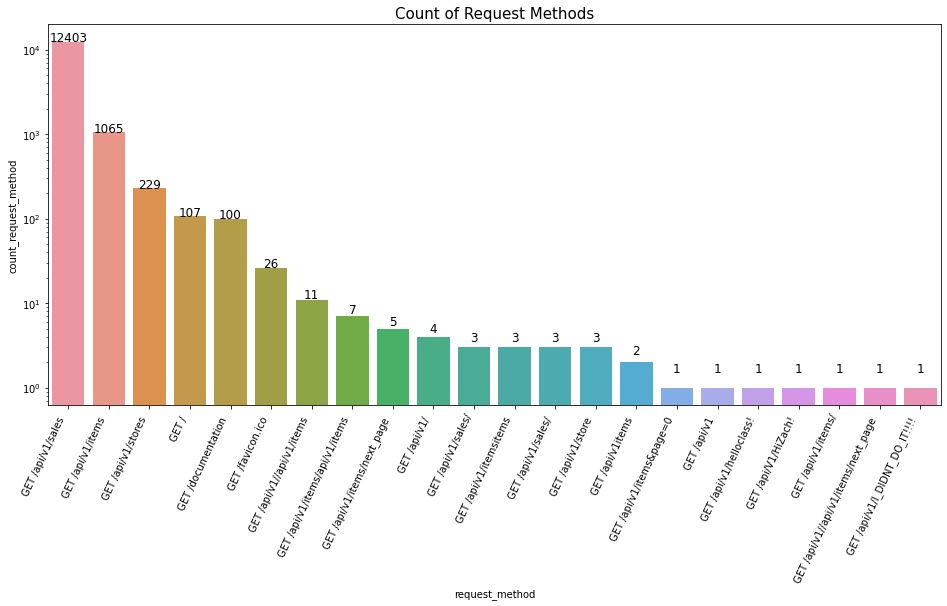

In [31]:
plt.figure(figsize = (16,7))
bar = sns.barplot(data=request_method_df, x = 'request_method', y = 'count_request_method', log=True)
plt.xticks(ha = 'right', rotation = 65)
plt.title('Count of Request Methods', fontsize = 15)

for row in range(len(request_method_df.count_request_method)):
    bar.text(x = row, y = request_method_df.count_request_method[row]+.51, 
             s = request_method_df.count_request_method[row],
            fontdict={ 'ha':'center', 'fontsize': 12})

plt.show()

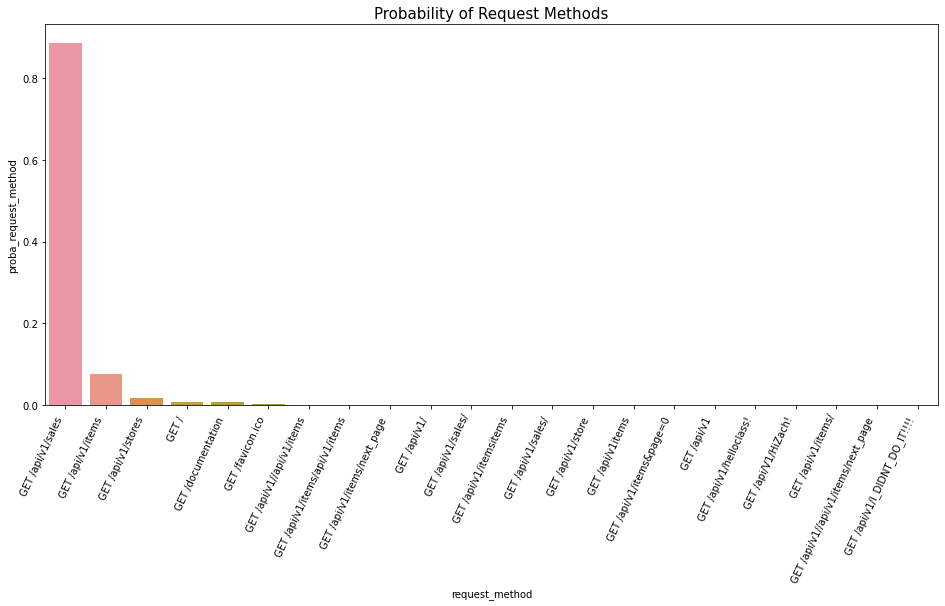

In [32]:
plt.figure(figsize = (16,7))
sns.barplot(data=request_method_df, x = 'request_method', y = 'proba_request_method')
plt.xticks(ha = 'right', rotation = 65)
plt.title('Probability of Request Methods', fontsize = 15)

plt.show()

In [33]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales,200,511963,NaN,python-requests/2.21.0,0.488246
